
# Modeliranje i dekompozicija podataka

Iako algoritmi za automatsko modeliranje kao što je `auto_arima` mogu proizvesti modele koji predviđaju sa zadovoljavajućom preciznosti, važno je razumjeti parametre odabranog modela i usporediti ih sa stvarnim svojstvima odabranog skupa podataka.


In [21]:
import warnings

import matplotlib.pyplot as plt
import pandas as pd

from statsmodels.tsa.seasonal import STL

warnings.filterwarnings("ignore")

## Učitavanje i proširivanje podataka s ciljnom varijablom

Podatke razdvajamo u više skupova ovisno o kojem se hotelu radi (`hotel_id`) jer je očekivano da će se podaci za svaki od hotela ponašati različito i da će se predviđanje popunjenosti raditi za svaki hotel pojedinačno.

Ciljna varijabla je ukupan broj gostiju u nekom hotelu u nekom vremenskom periodu, gdje smo odredili da vremenski period može biti:
- dan
- tjedan
- mjesec
- godina

Čišćenje i proširivanje podataka radimo na način koji je opisan u bilježnici `ARIMA_occupancy_prediction.ipynb`.

In [13]:
data = pd.read_parquet('../data/raw/export_df.parquet')
data.head()

,hotel_id,datum_dolaska,datum_kreiranja_rezervacije,datum_odjave,datum_otkazivanja_rezervacije,broj_odraslih_gostiju,broj_djece_gostiju,zemlja_gosta,kanal_prodaje_id,tip_sobe_id,cijena_nocenja,status_rezervacije,rezervacija_id,gost_id
0,0,2015-07-01,2015-01-21,2015-07-01,None,2,0.0,PRT,0,0,100.000000,Check-Out,1313223,1077152
1,0,2015-07-01,2015-06-10,2015-07-01,None,2,0.0,PRT,0,0,100.000000,Check-Out,1313224,1017906
2,0,2015-07-01,2015-05-13,2015-07-02,None,1,0.0,GBR,0,1,64.991345,Check-Out,1313225,1039896
3,0,2015-07-01,2014-05-30,2015-07-02,None,1,0.0,GBR,1,1,74.368897,Check-Out,1313226,1008245
4,0,2015-07-01,2014-07-06,2015-07-03,None,2,0.0,GBR,2,1,130.973278,Check-Out,1313227,1093703


In [14]:
# Osnovno čišćenje podataka
data = data[~(data['zemlja_gosta']=='0')]
data['broj_djece_gostiju'] = data['broj_djece_gostiju'].astype(int)

# Ukupan broj gostiju po zapisu
data['ukupno_gostiju'] = data['broj_odraslih_gostiju'] + data['broj_djece_gostiju']

# Duljina boravka
data['duljina_boravka'] = data['datum_odjave'] - data['datum_dolaska']
data['duljina_boravka'] = data['duljina_boravka'].dt.days

# Rezervacije bez gostiju
data = data[data['ukupno_gostiju'] != 0]

# Otkazane rezervacije
data = data[~data['datum_otkazivanja_rezervacije'].notna()]
data = data.reset_index(drop=True)

# Razdvoji podatke iz različitih hotela
dataResort = data[data['hotel_id'] == 0]
dataCity = data[data['hotel_id'] == 1]

assert len(dataResort) + len(dataCity) == len(data)

print(f"Resort ima {len(dataResort)} zapisa")
print(f"City ima {len(dataCity)} zapisa")

Resort ima 28506 zapisa
City ima 46047 zapisa


In [18]:
# Ciljne varijable - hotel 0
NumberOfGuestsResort = dataResort[['datum_dolaska', 'ukupno_gostiju']]

NumberOfGuestsDailyResort = dataResort['ukupno_gostiju'].groupby(dataResort['datum_dolaska']).sum()
NumberOfGuestsDailyResort = NumberOfGuestsDailyResort.resample('d').sum().to_frame()

NumberOfGuestsWeeklyResort = dataResort['ukupno_gostiju'].groupby(dataResort['datum_dolaska']).sum()
NumberOfGuestsWeeklyResort = NumberOfGuestsWeeklyResort.resample('w').sum().to_frame()

NumberOfGuestsMonthlyResort = dataResort['ukupno_gostiju'].groupby(dataResort['datum_dolaska']).sum()
NumberOfGuestsMonthlyResort = NumberOfGuestsMonthlyResort.resample('m').sum().to_frame()

NumberOfGuestsYearlyResort = dataResort['ukupno_gostiju'].groupby(dataResort['datum_dolaska']).sum()
NumberOfGuestsYearlyResort = NumberOfGuestsYearlyResort.resample('y').sum().to_frame()

NumberOfGuestsMonthlyResort.head()

,ukupno_gostiju
datum_dolaska,
2015-07-31,2300
2015-08-31,2318
2015-09-30,2013
2015-10-31,2108
2015-11-30,1534


In [20]:
# Ciljne varijable - hotel 1
NumberOfGuestsCity = dataCity[['datum_dolaska', 'ukupno_gostiju']]

NumberOfGuestsDailyCity = dataCity['ukupno_gostiju'].groupby(dataCity['datum_dolaska']).sum()
NumberOfGuestsDailyCity = NumberOfGuestsDailyCity.resample('d').sum().to_frame()

NumberOfGuestsWeeklyCity = dataCity['ukupno_gostiju'].groupby(dataCity['datum_dolaska']).sum()
NumberOfGuestsWeeklyCity = NumberOfGuestsWeeklyCity.resample('w').sum().to_frame()

NumberOfGuestsMonthlyCity = dataCity['ukupno_gostiju'].groupby(dataCity['datum_dolaska']).sum()
NumberOfGuestsMonthlyCity = NumberOfGuestsMonthlyCity.resample('m').sum().to_frame()

NumberOfGuestsYearlyCity = dataCity['ukupno_gostiju'].groupby(dataCity['datum_dolaska']).sum()
NumberOfGuestsYearlyCity = NumberOfGuestsYearlyCity.resample('y').sum().to_frame()

NumberOfGuestsMonthlyCity.head()

,ukupno_gostiju
datum_dolaska,
2015-01-31,206
2015-02-28,0
2015-03-31,0
2015-04-30,0
2015-05-31,1072


## STL dekompozicija

### Hotel 0

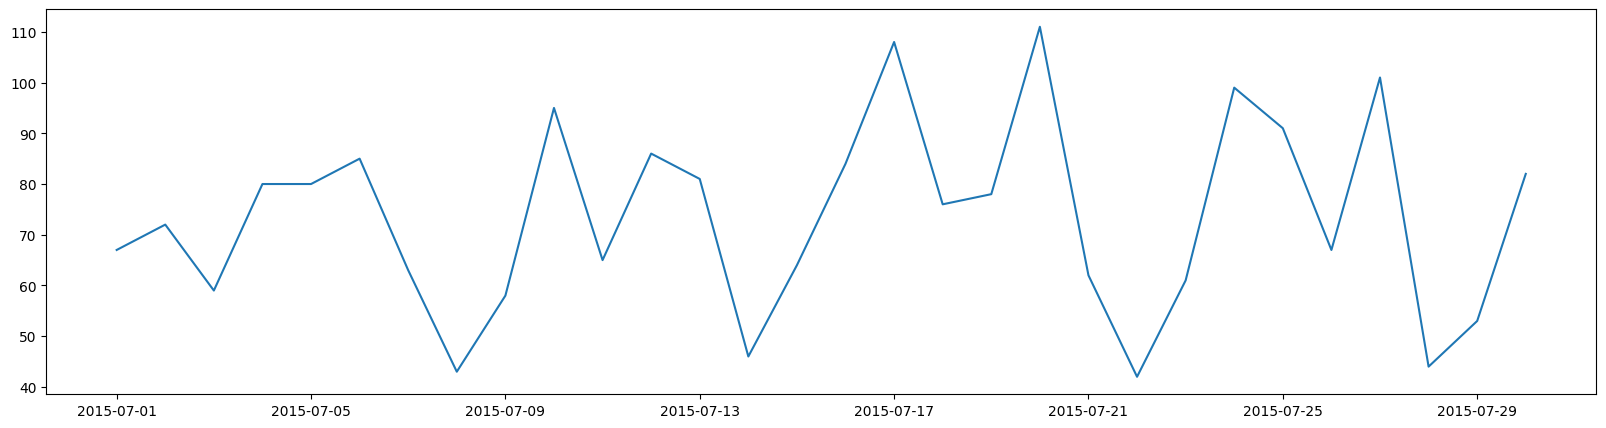

In [36]:
plt.figure(figsize=(20,5))
plt.plot(NumberOfGuestsDailyResort[:30])
plt.show()

dodat komentar vezan uz t.window, s.window, robust i periodicnost (7 - daily data with a weekly pattern)
red velicine na y osi

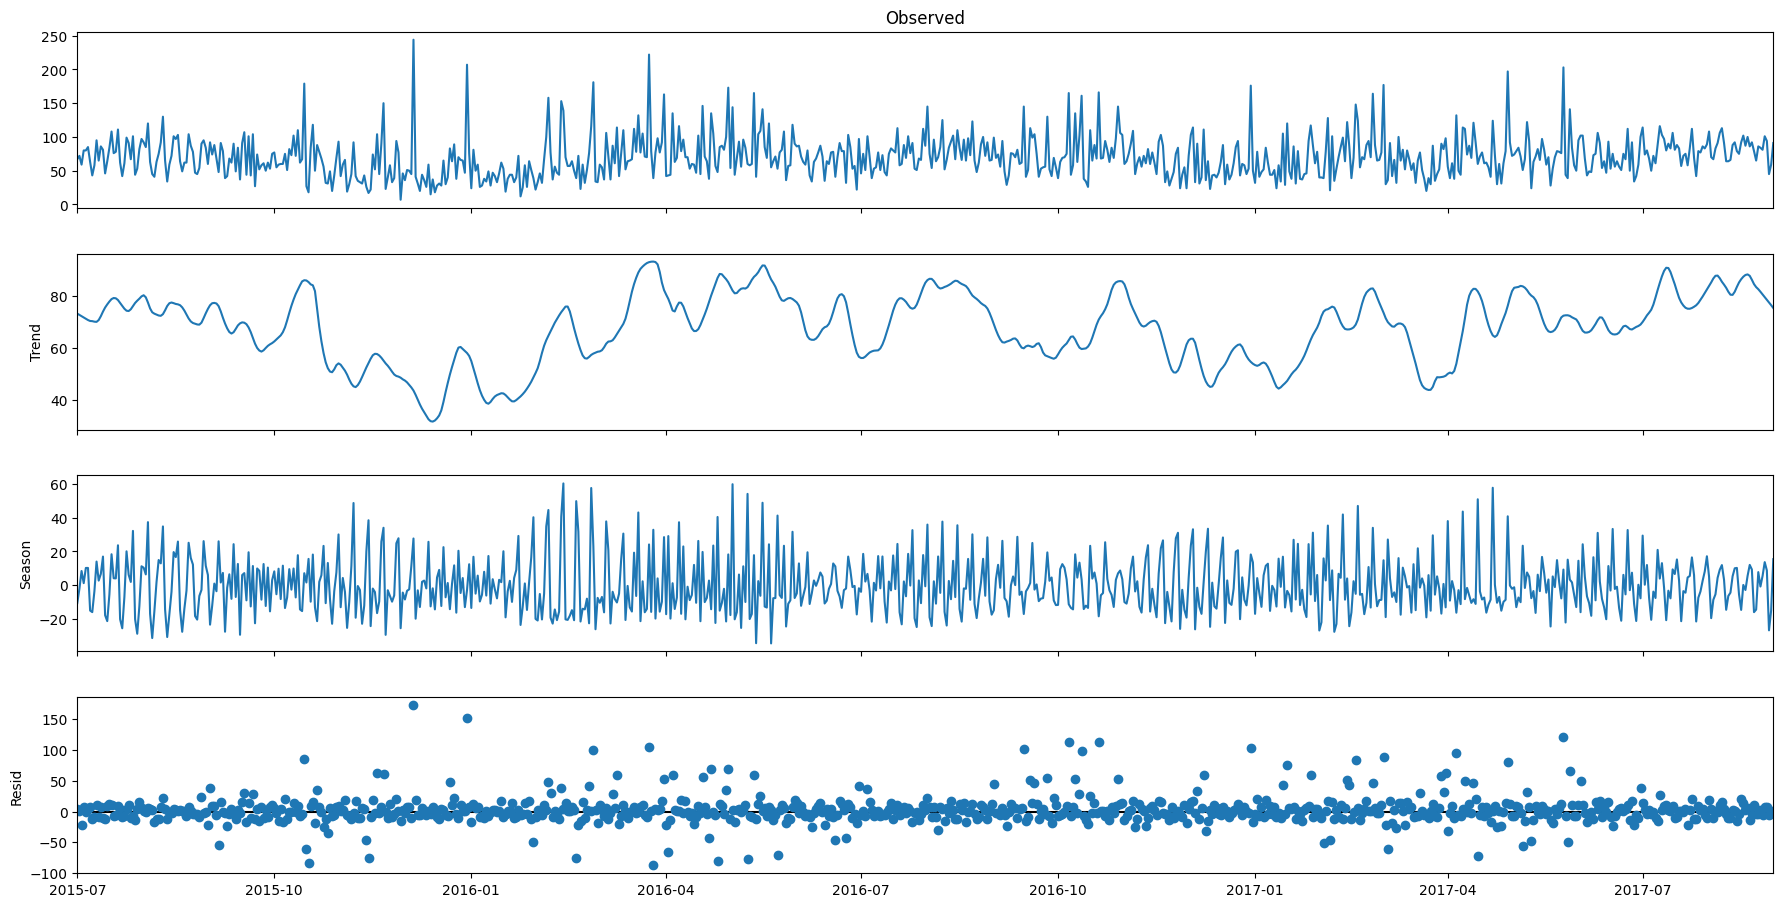

In [45]:
stl = STL(NumberOfGuestsDailyResort, period=7, robust=True)
res = stl.fit()
fig = res.plot()
fig.set_figwidth(20)
fig.set_figheight(10)

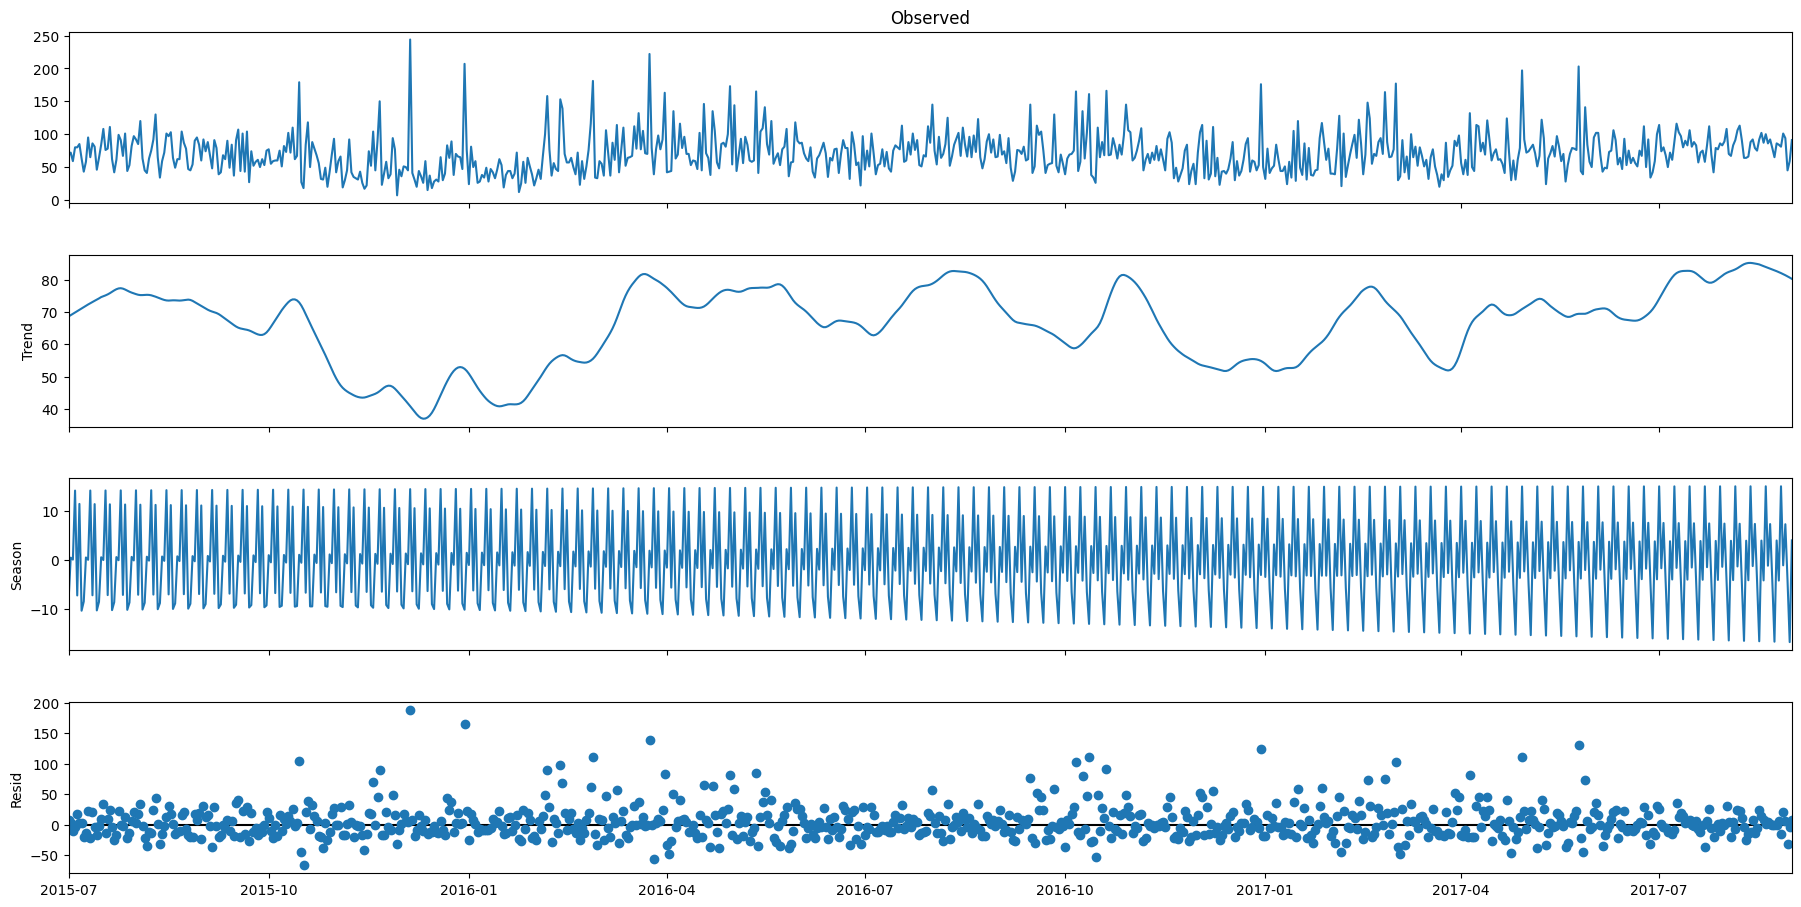

In [62]:
stl = STL(NumberOfGuestsDailyResort, period=7, trend=31, seasonal=365, robust=True)
res = stl.fit()
fig = res.plot()
fig.set_figwidth(20)
fig.set_figheight(10)

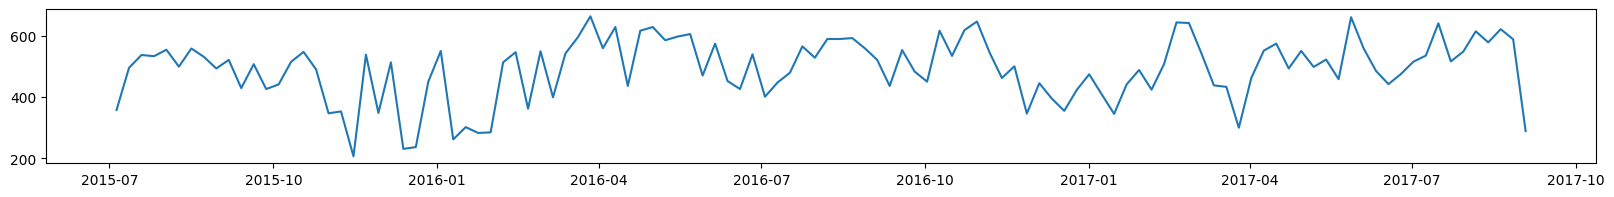

In [67]:
plt.figure(figsize=(20,2))
plt.plot(NumberOfGuestsWeeklyResort)
plt.show()

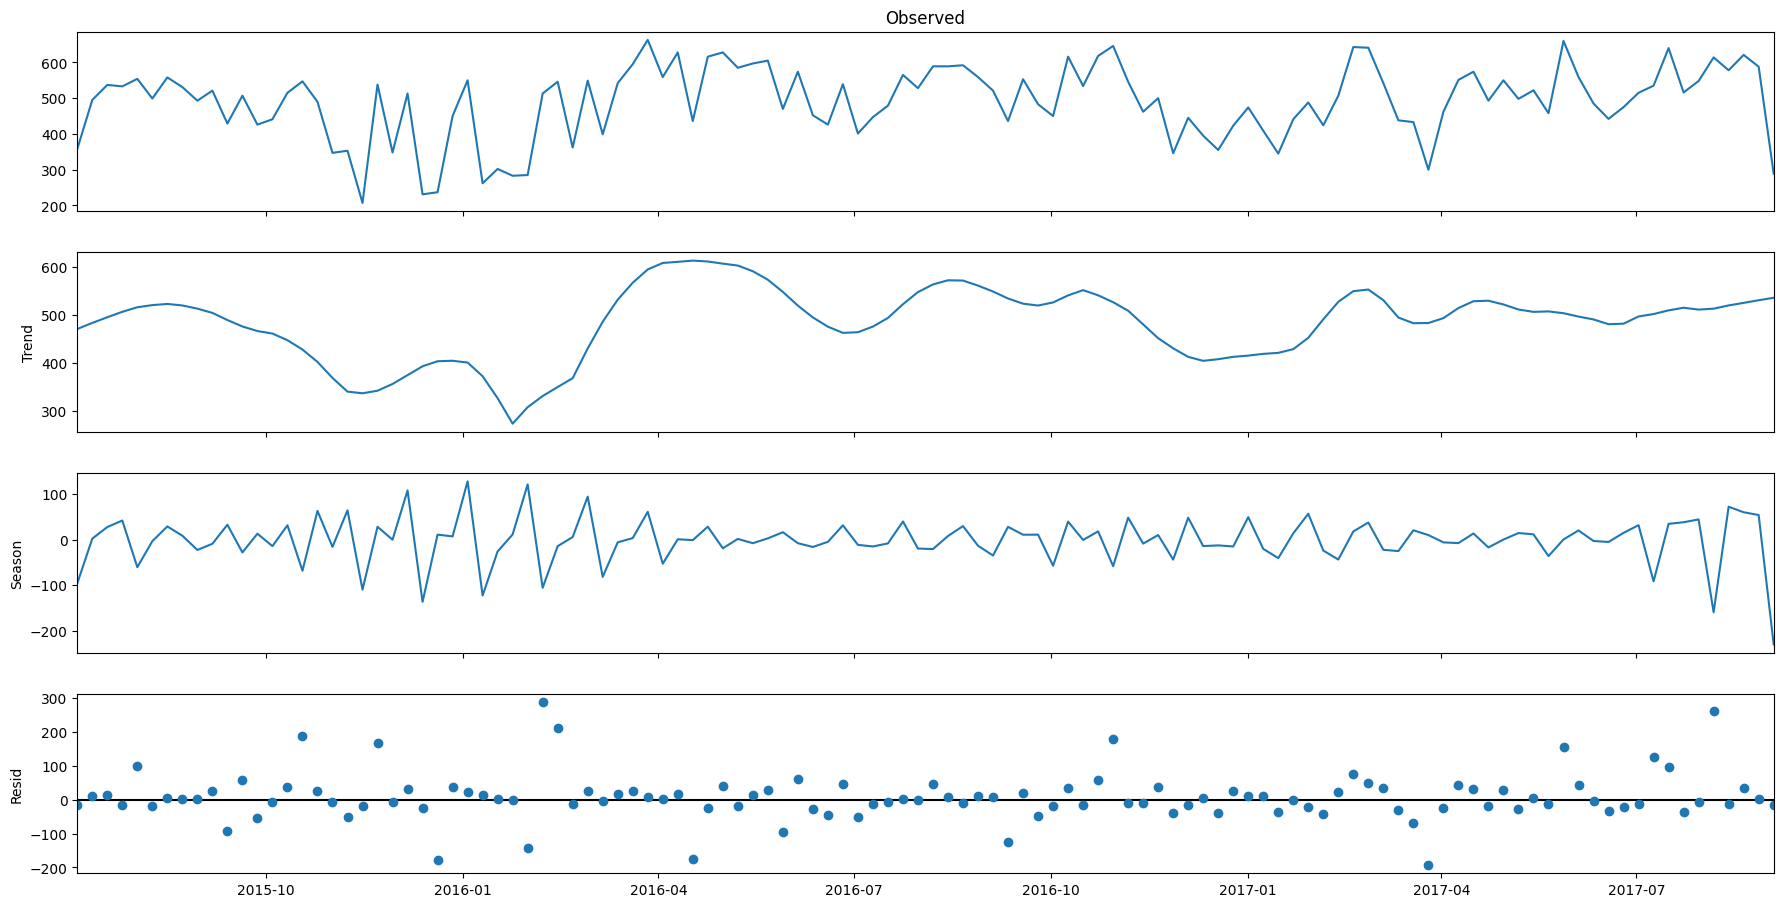

In [76]:
stl = STL(NumberOfGuestsWeeklyResort, period=4, robust=True)
res = stl.fit()
fig = res.plot()
fig.set_figwidth(20)
fig.set_figheight(10)

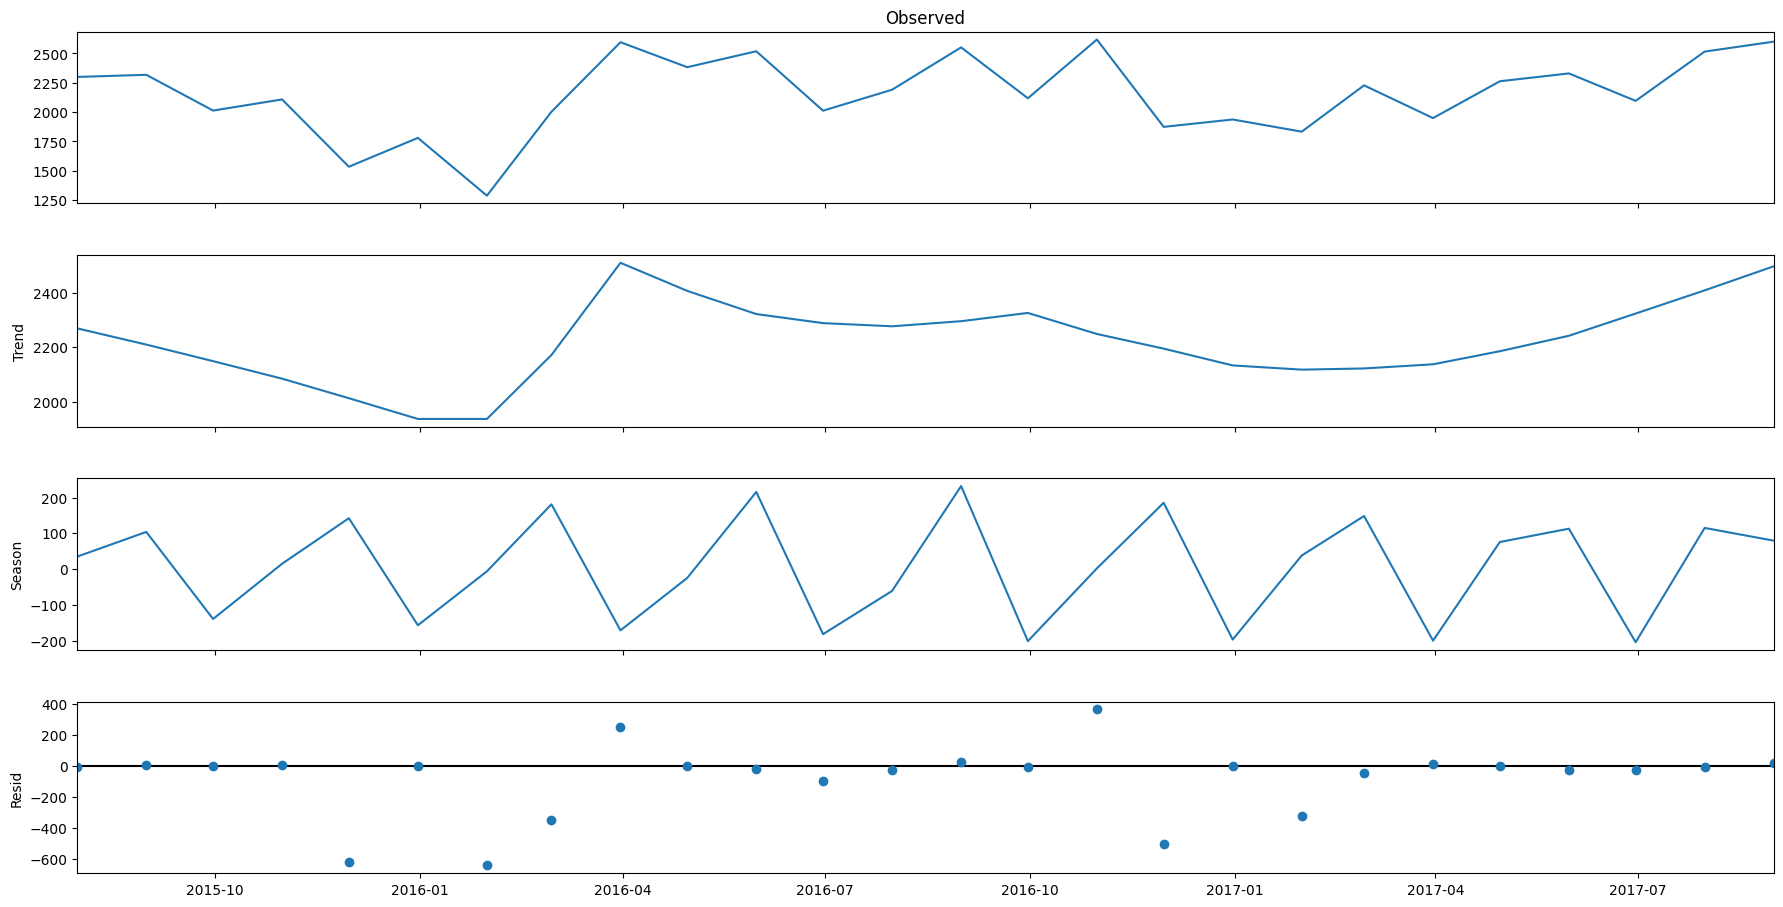

In [84]:
stl = STL(NumberOfGuestsMonthlyResort, period=3, robust=True)
res = stl.fit()
fig = res.plot()
fig.set_figwidth(20)
fig.set_figheight(10)